# Zero-Cost NAS Examples

In this notebook, we provide examples of how to use zero-cost proxies within NAS algorithms. Specifically, we provide implementations of **random search** and **aging evolution search** with and without zero-cost warmup and move proposal.

_note: the results in our ICLR paper were produced by a different (internal) AutoML tool that we are not publicly releasing. While it should be possible to get this notebook to exactly match our tool, we haven't done that here. We just provide examples to showcase the possible advantages of using zero-cost proxies._

In [1]:
from nas_201_api import NASBench201API as API
api = API('../data/NAS-Bench-201-v1_0-e61699.pth')
api.verbose = False

try to create the NAS-Bench-201 api from ../data/NAS-Bench-201-v1_0-e61699.pth


In [2]:
import pickle
synflow_proxy=[]
f = open('../results_release/nasbench2/nb2_cf100_seed42_dlrandom_dlinfo1_initwnone_initbnone.p','rb')
while(1):
    try:
        d = pickle.load(f)
        synflow_proxy.append(d['logmeasures']['synflow'])
    except EOFError:
        break
f.close()

In [3]:
#dicts to map from index to spec or spec to index
#spec is the model description within NAS, in our case we use an encoding [5, 5, 5, 5, 5, 5]
#this is a length-6 vector, with each entry having a value between 0-4 
#this is sufficient to describe any NAS-Bench-201 cell

_opname_to_index = {
    'none': 0,
    'skip_connect': 1,
    'nor_conv_1x1': 2,
    'nor_conv_3x3': 3,
    'avg_pool_3x3': 4
}

def get_spec_from_arch_str(arch_str):
    nodes = arch_str.split('+')
    nodes = [node[1:-1].split('|') for node in nodes]
    nodes = [[op_and_input.split('~')[0]  for op_and_input in node] for node in nodes]

    spec = [_opname_to_index[op] for node in nodes for op in node]
    return spec

idx_to_spec = {}
for i, arch_str in enumerate(api):
    idx_to_spec[i] = get_spec_from_arch_str(arch_str)

spec_to_idx = {}
for idx,spec in idx_to_spec.items():
    spec_to_idx[str(spec)] = idx

In [4]:
import random
import copy
random.seed = 42
def random_spec():
    return random.choice(list(idx_to_spec.values()))

def mutate_spec(old_spec):
    idx_to_change = random.randrange(len(old_spec))
    entry_to_change = old_spec[idx_to_change]
    possible_entries = [x for x in range(5) if x != entry_to_change]
    new_entry = random.choice(possible_entries)
    new_spec = copy.copy(old_spec)
    new_spec[idx_to_change] = new_entry
    return new_spec

def mutate_spec_zero_cost(old_spec):
    possible_specs = []
    for idx_to_change in range(len(old_spec)): 
        entry_to_change = old_spec[idx_to_change]
        possible_entries = [x for x in range(5) if x != entry_to_change]
        for new_entry in possible_entries:
            new_spec = copy.copy(old_spec)
            new_spec[idx_to_change] = new_entry
            possible_specs.append((synflow_proxy[spec_to_idx[str(new_spec)]], new_spec))
    best_new_spec = sorted(possible_specs, key=lambda i:i[0])[-1][1]
    if random.random() > 0.75:
        best_new_spec = random.choice(possible_specs)[1]
    return best_new_spec

In [5]:
def random_combination(iterable, sample_size):
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), sample_size))
    return tuple(pool[i] for i in indices)

In [6]:
def run_evolution_search(max_trained_models=1000, 
                         pool_size=64, 
                         tournament_size=10, 
                         zero_cost_warmup=0, 
                         zero_cost_move=False):
    
    best_valids, best_tests = [0.0], [0.0]
    pool = []   # (validation, spec) tuples
    num_trained_models = 0

    # fill the initial pool
    if zero_cost_warmup > 0:
        zero_cost_pool = []
        for _ in range(zero_cost_warmup):
            spec = random_spec()
            spec_idx = spec_to_idx[str(spec)]
            zero_cost_pool.append((synflow_proxy[spec_idx], spec))
            zero_cost_pool = sorted(zero_cost_pool, key=lambda i:i[0], reverse=True)
    for i in range(pool_size):
        if zero_cost_warmup > 0:
            spec = zero_cost_pool[i][1]
        else:
            spec = random_spec()
        info = api.get_more_info(spec_to_idx[str(spec)], 'cifar100', iepoch=None, hp='200', is_random=False)
        num_trained_models += 1
        pool.append((info['valid-accuracy'], spec))

        if info['valid-accuracy'] > best_valids[-1]:
            best_valids.append(info['valid-accuracy'])
        else:
            best_valids.append(best_valids[-1])
            
        if info['test-accuracy'] > best_tests[-1]:
            best_tests.append(info['test-accuracy'])
        else:
            best_tests.append(best_tests[-1])

    # After the pool is seeded, proceed with evolving the population.
    while(1):
        sample = random_combination(pool, tournament_size)
        best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
        if zero_cost_move:
            new_spec = mutate_spec_zero_cost(best_spec)
        else:
            new_spec = mutate_spec(best_spec)

        info = api.get_more_info(spec_to_idx[str(new_spec)], 'cifar100', iepoch=None, hp='200', is_random=False)
        num_trained_models += 1

        # kill the oldest individual in the population.
        pool.append((info['valid-accuracy'], new_spec))
        pool.pop(0)

        if info['valid-accuracy'] > best_valids[-1]:
            best_valids.append(info['valid-accuracy'])
        else:
            best_valids.append(best_valids[-1])
            
        if info['test-accuracy'] > best_tests[-1]:
            best_tests.append(info['test-accuracy'])
        else:
            best_tests.append(best_tests[-1])

        if num_trained_models >= max_trained_models:
            break
    best_tests.pop(0)
    best_valids.pop(0)
    return best_valids, best_tests

In [7]:
def run_random_search(max_trained_models=1000, 
                      zero_cost_warmup=0):
    
    best_valids, best_tests = [0.0], [0.0]
    pool = []   # (validation, spec) tuples
    num_trained_models = 0

    # fill the initial pool
    if zero_cost_warmup > 0:
        zero_cost_pool = []
        for _ in range(zero_cost_warmup):
            spec = random_spec()
            spec_idx = spec_to_idx[str(spec)]
            zero_cost_pool.append((synflow_proxy[spec_idx], spec))
            zero_cost_pool = sorted(zero_cost_pool, key=lambda i:i[0], reverse=True)
    for i in range(max_trained_models):
        if i < zero_cost_warmup:
            spec = zero_cost_pool[i][1]
        else:
            spec = random_spec()
        info = api.get_more_info(spec_to_idx[str(spec)], 'cifar100', iepoch=None, hp='200', is_random=False)

        if info['valid-accuracy'] > best_valids[-1]:
            best_valids.append(info['valid-accuracy'])
        else:
            best_valids.append(best_valids[-1])
            
        if info['test-accuracy'] > best_tests[-1]:
            best_tests.append(info['test-accuracy'])
        else:
            best_tests.append(best_tests[-1])
            
    best_tests.pop(0)
    best_valids.pop(0)
    return best_valids, best_tests

In [8]:
from tqdm import tqdm
num_rounds = 10
length = 300
ae, ae_warmup, ae_move, rand, rand_warmup = [], [], [], [], []
for _ in tqdm(range(num_rounds)):
    ae_best_valids, ae_best_tests = run_evolution_search(max_trained_models=length)
    ae.append(ae_best_tests)
    ae_warmup_best_valids, ae_warmup_best_tests = run_evolution_search(max_trained_models=length, zero_cost_warmup=3000)
    ae_warmup.append(ae_warmup_best_tests)
    ae_move_best_valids, ae_move_best_tests = run_evolution_search(max_trained_models=length, zero_cost_move=True)
    ae_move.append(ae_move_best_tests)
    rand_best_valids, rand_best_tests = run_random_search(max_trained_models=length)
    rand.append(rand_best_tests)
    rand_warmup_best_valids, rand_warmup_best_tests = run_random_search(max_trained_models=length, zero_cost_warmup=3000)
    rand_warmup.append(rand_warmup_best_tests)

100%|██████████| 10/10 [00:18<00:00,  1.80s/it]


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_experiment(exp_list, title):
    def plot_exp(exp, label):
        exp = np.array(exp) 
        q_75 = np.quantile(exp, .75, axis=0)
        q_25 = np.quantile(exp, .25, axis=0)
        mean = np.mean(exp, axis=0)
        plt.plot(mean, label=label)
        plt.fill_between(range(len(q_25)), q_25, q_75, alpha=0.1)
    for exp,ename in exp_list:
        plot_exp(exp,ename)
    plt.grid()
    plt.xlabel('Trained Models')
    plt.ylabel('Test Accuracy')
    plt.ylim(70,73.6)
    plt.legend()
    plt.title(title)
    plt.show()

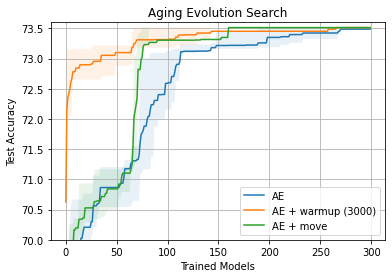

In [10]:
plot_experiment([(ae,'AE'), (ae_warmup,'AE + warmup (3000)'), (ae_move,'AE + move')], 'Aging Evolution Search')

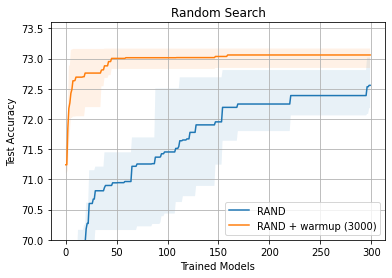

In [11]:
plot_experiment([(rand,'RAND'), (rand_warmup,'RAND + warmup (3000)')], 'Random Search')